# Setup inicial

In [1]:
# Paths & URLs

import os

# Directorio base
#PATH_BASE = '/content/drive/MyDrive/proximity'
#PATH_BASE = 'C:\\Users\\User\\Documents\\Proyecto Proximity'
PATH_BASE = 'E:\\files\\Documents\\Proyecto Proximity'

# Data release 70
DATA_RELEASE_PATH = os.path.join(PATH_BASE, 'datalake_sorted')
DR70_PATH = os.path.join(PATH_BASE, 'DR70')
DR70_LABELS_PATH = os.path.join(DR70_PATH, 'labels.csv')

# Data release 217
DR217_PATH = os.path.join(PATH_BASE, 'DR217')
DR217_CT_PATH = os.path.join(DR217_PATH, 'DR217_studies')
# Used for normalization of the intensity values for each CT
DR217_CT_HISTOGRAM_LANDMARKS_PATH = os.path.join(DR217_PATH, 'DR217_histogram_landmarks.npy')
DR217_LABELS_PATH = os.path.join(DR217_PATH, 'DR217_labels.csv')
# Embeddings ResNet18 DR217
DR217_RESNET_EMBEDDINGS_PATH = os.path.join(DR217_PATH, 'DR217_resnet18_embeddings')


# CTs in Nibabel format
CT_NIBABEL_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs')
CT_NIBABEL_ZERO_PADDED_PATH = os.path.join(PATH_BASE, 'DR70', 'CTs', 'zero_padded')

# Embeddings visuales de CTs
CT_EMBEDDINGS_PATH = DATA_RELEASE_PATH + '/visual_embeddings'


# Etiquetas de los CTs del data release actual
#CT_LABELS_CSV_PATH = DATA_RELEASE_PATH + '/labels.csv'

# Data release (CTs + etiquetas) organizados en un DataFrame
CT_DATASET_DF_HDF_PATH = os.path.join(PATH_BASE, 'dataset_df.h5')
CT_DATASET_DF_PICKLE_PATH = os.path.join(PATH_BASE, 'dataset_df.pickle')

# URLs de modelos visuales
RESNET18_URL = 'microsoft/resnet-18'

# Path que contiene los resnet50 embeddings de CTs del data release actual
CT_RESNET18_EMBEDDINGS_PATH = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18')
CT_RESNET18_EMBEDDINGS_PATH_ZERO_PADDED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'zero_padded')
CT_RESNET18_EMBEDDINGS_PATH_NN_INTERPOLATED = os.path.join(DR70_PATH, 'visual_embeddings', 'resnet18', 'nn_interpolated')

In [54]:
import os
import pandas as pd
import numpy as np
import torch
import torchio as tio
from torch.utils.data import Dataset, random_split, RandomSampler, BatchSampler
from scipy.spatial.distance import hamming
import random
import logging

# Set seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

logging.basicConfig(level=logging.INFO)

class ProximityCTDataset(tio.SubjectsDataset):
    def __init__(self, ct_base_path, ct_image_ids, ct_labels_path, histogram_landmarks=None):
        
        self.labels_df = pd.read_csv(
            ct_labels_path, 
            header=0, 
            #index_col=0, 
            dtype={'CT': str, 'condensacion': int, 'nodulos': int, 'quistes': int}
        )
        
        # Mark those samples that have non-binary label values as not valid
        self.labels_df['labels_are_valid'] = self.labels_df.apply(self._determine_valid_labels, axis=1)

        s_list = []
        for s_id in ct_image_ids:
            label_attribs = self._get_ct_label_data(s_id)
            s = tio.Subject(
                t1 = tio.ScalarImage(os.path.join(ct_base_path, s_id)),
                image_path = os.path.join(ct_base_path, s_id),
                name = s_id,
                **label_attribs
            )
            s_list.append(s)

        # Transforms and augmentations to apply to images in the dataset
        s_transforms = tio.Compose([
            tio.ToCanonical(),
            tio.Resample(1),
            tio.CropOrPad(target_shape=(300, 300, 300), padding_mode='constant'),
            tio.Clamp(out_min=-1000, out_max=200), #Clip Hounsfield units
            tio.RescaleIntensity(out_min_max=(0, 1)),
        ])

        # Filter out those samples with invalid labels
        s_list = [s for s in s_list if s['labels_are_valid']]
        
        super().__init__(s_list, transform=s_transforms, load_getitem=False)
        
    def _determine_valid_labels(self, row):
        if (row['condensacion'] == 1 or row['condensacion'] == 0) \
        and (row['nodulos'] == 1 or row['nodulos'] == 0) \
        and (row['quistes'] == 1 or row['quistes'] == 0):
            return True
        return False

    def _get_ct_label_data(self, ct_code):
        result = self.labels_df.loc[self.labels_df['CT'] == ct_code+'AN'].to_dict('records')
        if result:
            r = result[0]
            r['labels_as_vector'] = self._get_label_vector(r)
            return r
        else:
            return {'labels_are_valid': False}

    def _get_label_vector(self, labels_dict):
        c = labels_dict['condensacion']
        n = labels_dict['nodulos']
        q = labels_dict['quistes']
        return [c, n, q]

In [55]:
import random

subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]

subject_subset = random.sample(subject_list, 5)

dataset = ProximityCTDataset(DR217_CT_PATH, subject_list, DR217_LABELS_PATH)

torch.Size([300, 300, 300])
tensor(0.)
tensor(1.)


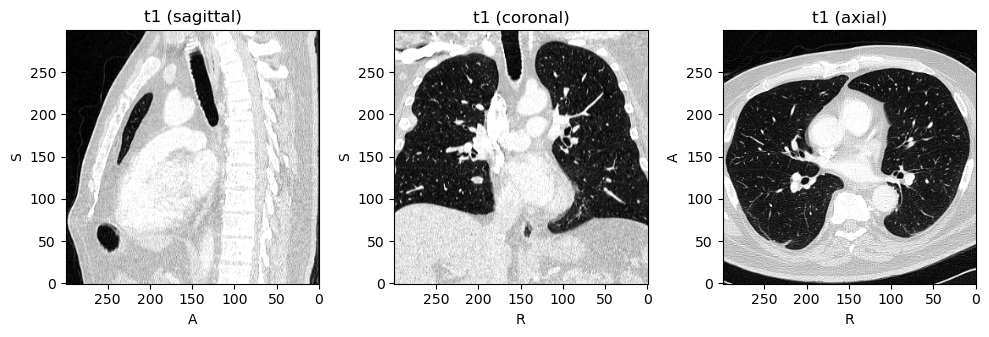

In [57]:
s = dataset[2]

print(s['t1']['data'][0].shape)
print(torch.min(s['t1']['data'][0]))
print(torch.max(s['t1']['data'][0]))
#print(s['t1']['data'][0])
s.plot(figsize=(10, 30))

# Experimentación con normalización por histograma (ignorar pues terminé por no aplicarlo al preprocesamiento)

  0%|          | 0/5 [00:00<?, ?it/s]

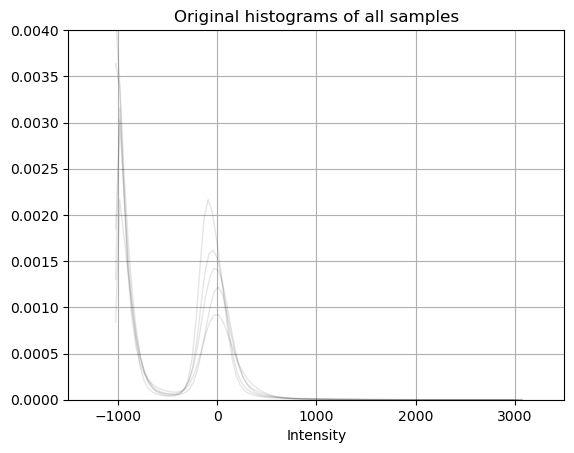

In [10]:
from scipy import stats
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.1, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)


fig, ax = plt.subplots(dpi=100)
for s in tqdm(dataset):
    tensor = s['t1']['data']
    #if 'HH' in path.name: color = 'red'
    #elif 'Guys' in path.name: color = 'green'
    #elif 'IOP' in path.name: color = 'blue'
    plot_histogram(ax, tensor)
ax.set_xlim(-1500, 3500)
ax.set_ylim(0, 0.004);
ax.set_title('Original histograms of all samples')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

In [15]:
subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]
subject_path_list = [os.path.join(DR217_CT_PATH, s_id) for s_id in subject_list]

landmarks = tio.HistogramStandardization.train(
    subject_path_list,
    output_path=DR217_CT_HISTOGRAM_LANDMARKS_PATH,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

  0%|          | 0/217 [00:00<?, ?it/s]


Trained landmarks: [  0.      2.062   4.523   6.237   8.569  18.213  36.948  53.601  60.422
  62.771  65.159  71.262 100.   ]


  0%|          | 0/5 [00:00<?, ?it/s]

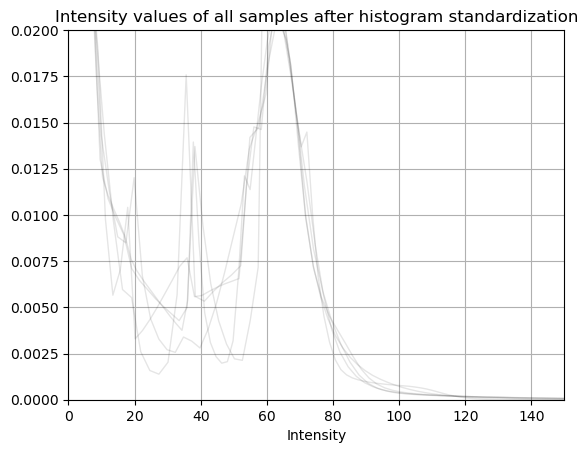

In [22]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy import stats

landmarks_dict = {'t1': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

subject_list = [dirname for dirname in os.listdir(DR217_CT_PATH)]
subject_subset = random.sample(subject_list, 5)
dataset = ProximityCTDataset(DR217_CT_PATH, subject_subset, DR217_LABELS_PATH)


def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.1, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)


fig, ax = plt.subplots(dpi=100)
for i ,sample in enumerate(tqdm(dataset)):
    standard = histogram_transform(sample)
    tensor = standard.t1.data
    #path = str(sample.mri.path)
    #if 'HH' in path: color = 'red'
    #elif 'Guys' in path: color = 'green'
    #elif 'IOP' in path: color = 'blue'
    plot_histogram(ax, tensor)
ax.set_xlim(0, 150)
ax.set_ylim(0, 0.02)
ax.set_title('Intensity values of all samples after histogram standardization')
ax.set_xlabel('Intensity')
ax.grid()
graph = None

[0, 1, 0]
tensor([[[[-1016,  -939,  -941,  ...,  -976, -1003,  -997],
          [ -866,  -787,  -907,  ...,  -913,  -972, -1002],
          [ -874,  -949, -1012,  ...,  -944, -1002, -1011],
          ...,
          [ -979,  -981,  -987,  ...,  -962, -1005,  -960],
          [ -740,  -735,  -883,  ...,  -896,  -987,  -989],
          [ -922,  -951,  -940,  ...,  -760,  -813,  -835]],

         [[-1016, -1000,  -983,  ..., -1003,  -968,  -934],
          [-1018,  -936,  -826,  ...,  -989,  -950,  -935],
          [ -714,  -848,  -853,  ...,  -934,  -883,  -879],
          ...,
          [ -834,  -883,  -939,  ...,  -956,  -993, -1006],
          [ -818,  -835,  -881,  ...,  -876,  -798,  -845],
          [ -974,  -994,  -901,  ...,  -862,  -790,  -752]],

         [[ -825,  -915, -1000,  ...,  -935,  -906,  -978],
          [-1008,  -996, -1019,  ..., -1010, -1007, -1006],
          [-1016,  -968,  -911,  ...,  -985,  -950,  -953],
          ...,
          [ -950,  -902,  -961,  ...,  -8

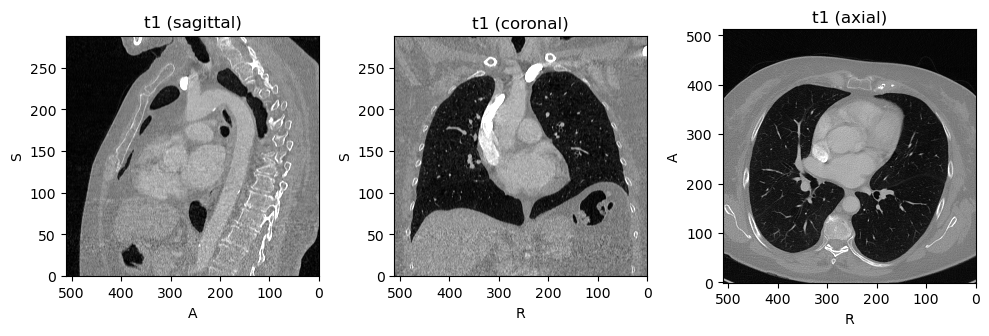

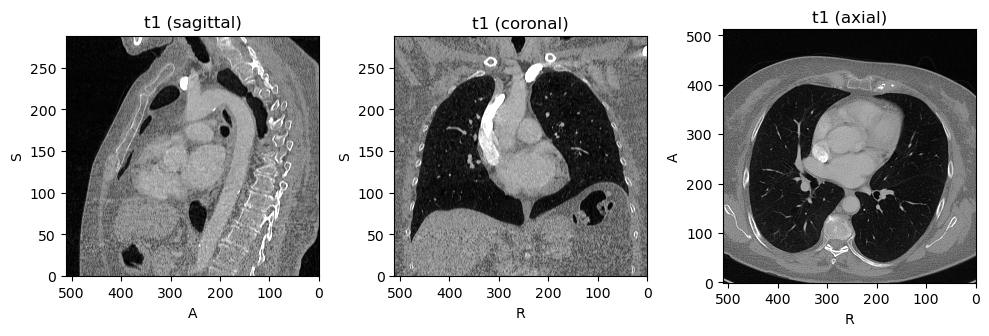

In [41]:
d = dataset[3]
rescaled_d = tio.RescaleIntensity(out_min_max=(0, 255))(d)
histogramed_d = histogram_transform(d)
print(d['labels_as_vector'])
print(d['t1']['data'])
print(rescaled_d['t1']['data'].int())
rescaled_d.plot(figsize=(10, 30))
histogramed_d.plot(figsize=(10, 30))


# Instanciar modelo ResNet y generar embeddings a partir de los CTs

In [58]:
from torch import nn
from torchvision import models

class CTEmbeddingModel(nn.Module):
    def __init__(self):
        super(CTEmbeddingModel, self).__init__()
        
        resnet = models.resnet18(weights='DEFAULT')
        self.features = nn.Sequential(*(list(resnet.children())[:-2]))

        '''
        #conv input torch.Size([1,83,512,14,14])
        self.reducingconvs = nn.Sequential(
            nn.Conv3d(28, 16, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            nn.ReLU(),
            
            #nn.Conv3d(16, 8, kernel_size = (3,3,3), stride=(3,1,1), padding=0),
            #nn.ReLU(),
            
            #nn.Conv3d(8, 4, kernel_size = (3,1,1), stride=(3,1,1), padding=0),
            #nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(16*170*3*3, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256), 
            nn.ReLU(True),
            nn.Dropout(0.5),
            
            nn.Linear(256, 2))
        '''
      
    def forward(self, x):
        print('input shape', x.shape)
        #x = x.permute(0, 3, 1, 2)
        #print(x.shape)
        shape = list(x.size())
        #example shape: [1,83,3,290,290]
        #example shape: [2,83,3,290,290]
        batch_size = int(shape[0])
        x = x.view(batch_size*100,3,300,300)
        x = self.features(x)
        print('resnet output shape:', x.size())
        '''
        x = x.view(batch_size,28,512,5,5)
        x = self.reducingconvs(x)
        #output is shape [batch_size, 16, 18, 3, 3]
        #print('reducingconvs output shape:', x.size())
        x = x.view(batch_size, 16*170*3*3)
        x = self.fc(x)
        '''
        return x

In [63]:
model = CTEmbeddingModel()
model.eval()
model.cuda()
with torch.no_grad():
    for s in tqdm(dataset):
        # input tensor comes in the range [0, 1]
        # only remaining step to complete Z-Normalization for ResNet is substrating the mean of 0.449.
        input_normalized = torch.tensor(s['t1']['data']).cuda() - 0.449
        name = s['name']
        embedding = model(input_normalized).cpu().numpy()
        label = np.array(s['labels_as_vector'])
        np.savez_compressed(os.path.join(DR217_RESNET_EMBEDDINGS_PATH, name), name=name, embedding=embedding, label=label)

  0%|          | 0/213 [00:00<?, ?it/s]

C:\Users\jpmm\AppData\Local\Temp\ipykernel_16984\1446670751.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_normalized = torch.tensor(s['t1']['data']).cuda() - 0.449


input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet output shape: torch.Size([100, 512, 10, 10])
input shape torch.Size([1, 300, 300, 300])
resnet 

[[38.4  0.   0.   0. ]
 [ 0.   1.   0.   0. ]
 [ 0.   0.   1.   0. ]
 [ 0.   0.   0.   1. ]]
(1, 10, 512, 512)
ScalarImage(shape: (1, 10, 512, 512); spacing: (1.00, 1.00, 1.00); orientation: RAS+; dtype: torch.IntTensor; memory: 10.0 MiB)
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


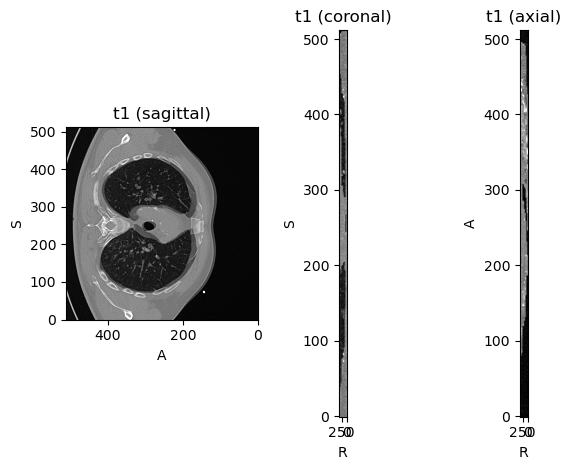

In [99]:
import numpy as np

s_list = [
    tio.Subject(
        t1 = tio.ScalarImage(os.path.join(CT_NIBABEL_PATH, subject_filename)),
        file_path = os.path.join(CT_NIBABEL_PATH, subject_filename),
    ) for subject_filename in subject_list]

shapes_list = [np.array(s.shape) for s in s_list]

shapes_arr = np.array(shapes_list)

max_depth = np.max(shapes_arr.T[1])

zoom_factor_list = [max_depth/sh[1] for sh in shapes_list]

print(depth_zoom_affine(zoom_factor_list[48]))

zoomed_s_list = [
    tio.Subject(
        t1 = tio.ScalarImage(os.path.join(CT_NIBABEL_PATH, subject_filename), affine=depth_zoom_affine(zf)),
        file_path = os.path.join(CT_NIBABEL_PATH, subject_filename),
    ) for subject_filename, zf in zip(subject_list, zoom_factor_list)
]


s_transforms = tio.Compose([
    tio.ToCanonical(),
    tio.RescaleIntensity(out_min_max=(0, 1)),
    tio.Resize((max_depth,-1,-1), image_interpolation='linear'),
    tio.Resample((1, 1, 1), image_interpolation='linear'),
    #tio.ZNormalization((0.485, 0.456, 0.406, 0.229, 0.224, 0.225)),
    #tio.RandomAffine(),
])

def depth_zoom_affine(zoom_factor):
    return np.array([[zoom_factor, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])

s_dataset = tio.SubjectsDataset(zoomed_s_list)
print(s_dataset[48].shape)
print(s_dataset[48].t1)
print(s_dataset[48].t1.affine)
tio.Resize((max_depth,-1,-1), image_interpolation='linear')(zoomed_s_list[48]).plot()

In [81]:
@interact(subject_id=(0, len(s_dataset)-1, 1), frame_index=(0, 383, 1), x_index=(0, 511, 1), y_index=(0, 511, 1))
def visualize_ct(subject_id=0, frame_index=0, x_index=0, y_index=0):
    ct_volume = s_transforms(s_dataset[subject_id])
    slice_0 = ct_volume[0, frame_index, :, :]
    slice_1 = ct_volume[0, :, x_index, :]
    slice_2 = ct_volume[0, :, :, y_index]
    print(slice_0.shape)
    show_ct_slices([slice_0, slice_1, slice_2], frame_index, x_index, y_index)

interactive(children=(IntSlider(value=0, description='subject_id', max=69), IntSlider(value=0, description='fr…

In [87]:
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom


class NiftiLoader:
    def __init__(self, folder_path, ct_target_depth=384, resize_strategy='nn_interpolation'):
        self.folder_path = folder_path
        self.ct_target_depth = ct_target_depth
        self.file_list = [file_name for file_name in os.listdir(self.folder_path) if file_name.endswith(".nii.gz")]
        self.resize_strategy = resize_strategy
    
    def __iter__(self):
        self.current_idx = 0
        return self

    def get_ct_id_dict(self):
        ct_id_dict = dict((file_name.split('.nii.gz')[0], i) for (i, file_name) in enumerate(self.file_list))
        return ct_id_dict

    def get_ct_info(self, ct_id):
        file_name = self.file_list[ct_id]
        file_path = os.path.join(self.folder_path, file_name)

        # Load the NIfTI file
        nifti_image = nib.load(file_path)
        return nifti_image.header

    def _fix_depth(self, pixel_ndarray):
        if pixel_ndarray.shape[0] < self.ct_target_depth:
            zoom_factor = self.ct_target_depth / pixel_ndarray.shape[0]
            frame_diff = self.ct_target_depth - pixel_ndarray.shape[0]
            x_size = pixel_ndarray.shape[1]
            y_size = pixel_ndarray.shape[2]
            if self.resize_strategy == "zero_padding":
                pixel_ndarray = np.append(pixel_ndarray, np.zeros(shape=(frame_diff, x_size, y_size)), axis=0)
            elif self.resize_strategy == "nn_interpolation":
                pixel_ndarray = zoom(pixel_ndarray, (zoom_factor, 1, 1), order=0)
            else:
                raise ValueError(f"Resize strategy '{self.resize_strategy}' not supported. Allowed values are 'zero_padding' and 'nn_interpolation'.")
        fixed_pixel_ndarray = pixel_ndarray.astype(np.int16)
        return fixed_pixel_ndarray
    
    def __next__(self):
        if self.current_idx < len(self.file_list):
            file_name = self.file_list[self.current_idx]
            file_path = os.path.join(self.folder_path, file_name)

            # Extract CT_ID from the file name
            ct_id = file_name.split('.nii.gz')[0]

            # Load the NIfTI file
            nifti_image = nib.load(file_path)

            # Access the 3D numpy array from the NIfTI image
            ct_volume = nifti_image.get_fdata()

            ct_volume = self._fix_depth(ct_volume)

            # Increment the index for the next iteration
            self.current_idx += 1

            # Return the tuple (CT_ID, CT_3D_array)
            return ct_id, ct_volume
        else:
            raise StopIteration

    def __getitem__(self, idx):
        if idx < len(self.file_list):
            file_name = self.file_list[idx]
            file_path = os.path.join(self.folder_path, file_name)

            # Extract CT_ID from the file name
            ct_id = file_name.split('.nii.gz')[0]

            # Load the NIfTI file
            nifti_image = nib.load(file_path)

            # Access the 3D numpy array from the NIfTI image
            ct_volume = nifti_image.get_fdata()

            ct_volume = self._fix_depth(ct_volume)

            # Return the tuple (CT_ID, CT_3D_array)
            return ct_id, ct_volume
        else:
            raise IndexError("Index out of range")

# Example usage:
folder_path = CT_NIBABEL_PATH
nifti_loader = NiftiLoader(folder_path,ct_target_depth=384, resize_strategy='nn_interpolation')
'''
# Using _iter_ method
for i, (ct_id, ct_volume) in enumerate(nifti_loader):
    print(f"({i+1}) CT ID: {ct_id}")
    print(f"CT Volume Shape: {ct_volume.shape}")
    print()

# Using _getitem_ method
ct_id, ct_volume = nifti_loader[0]
print(f"CT ID: {ct_id}, CT Volume Shape: {ct_volume.shape}")
'''


'\n# Using _iter_ method\nfor i, (ct_id, ct_volume) in enumerate(nifti_loader):\n    print(f"({i+1}) CT ID: {ct_id}")\n    print(f"CT Volume Shape: {ct_volume.shape}")\n    print()\n\n# Using _getitem_ method\nct_id, ct_volume = nifti_loader[0]\nprint(f"CT ID: {ct_id}, CT Volume Shape: {ct_volume.shape}")\n'

In [88]:
nifti_loader[0]

('1.3.12.2.1107.5.1.4.83504.30000020010601131176000000830',
 array([[[  1, 261, 102, ...,  20,  84, 163],
         [ 21,  57, 163, ..., 220, 122, 242],
         [ 86, 119,  37, ..., 221,  48,  69],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        [[  2,   6,  51, ...,  49,  84, 154],
         [ 98,  89,  38, ..., 135, 103, 170],
         [112,  95,  94, ..., 136,  62,  79],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        [[ 72,  26,   2, ...,  25, 196, 189],
         [ 80,  96,  22, ..., 121, 134, 130],
         [105,  76, 247, ...,  20,  54,  45],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        ...,
 
        [[ 13,  26,  90, ...,  20,  94,  85],


In [71]:
from ipywidgets import interact
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_ct_slices(slices, f_idx, x_idx, y_idx):
    slices_colors = ["red", "green", "blue"]
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice, cmap="gray")
        slice_dims = slices[i].shape
        axes[i].add_patch(Rectangle((1, 1), slice_dims[1]-5, slice_dims[0]-5,
                                          edgecolor=slices_colors[i],
                                          facecolor="none",
                                          lw=2))
        if i == 0:
            axes[i].axvline(x=y_idx, ymin=0, ymax=slice_dims[1]-1, color=slices_colors[2], linewidth=1)
            axes[i].axhline(y=x_idx, xmin=0, xmax=slice_dims[0]-1, color=slices_colors[1], linewidth=1)
            axes[i].set_title("Axial/transversal")
        elif i == 1:
            axes[i].axvline(x=y_idx, ymin=0, ymax=slice_dims[1]-1, color=slices_colors[2], linewidth=1)
            axes[i].axhline(y=f_idx, xmin=0, xmax=slice_dims[0]-1, color=slices_colors[0], linewidth=1)
            axes[i].set_title("Coronal")
        elif i == 2:
            axes[i].axvline(x=x_idx, ymin=0, ymax=slice_dims[1]-1, color=slices_colors[1], linewidth=1)
            axes[i].axhline(y=f_idx, xmin=0, xmax=slice_dims[0]-1, color=slices_colors[0], linewidth=1)
            axes[i].set_title("Sagital")
        
        



In [30]:
folder_path = CT_NIBABEL_PATH
nifti_loader_zero_padding = NiftiLoader(folder_path, ct_target_depth=384, resize_strategy='zero_padding')
ct_id_dict = nifti_loader.get_ct_id_dict()

@interact(ct_id=ct_id_dict.keys(), frame_index=(0, 383, 1), x_index=(0, 511, 1), y_index=(0, 511, 1))
def visualize_ct(ct_id, frame_index=0, x_index=0, y_index=0):
    if ct_id:
        ct_id, ct_volume = nifti_loader_zero_padding[ct_id_dict[ct_id]]
        slice_0 = ct_volume[frame_index, :, :]
        slice_1 = ct_volume[:, x_index, :]
        slice_2 = ct_volume[:, :, y_index]
        show_ct_slices([slice_0, slice_1, slice_2], frame_index, x_index, y_index)

NameError: name 'NiftiLoader' is not defined

In [90]:
nifti_loader_nn_interpolation = NiftiLoader(folder_path, ct_target_depth=384, resize_strategy='nn_interpolation')

@interact(ct_id=ct_id_dict.keys(), frame_index=(0, 383, 1), x_index=(0, 511, 1), y_index=(0, 511, 1))
def visualize_ct_nn_interpolation(ct_id, frame_index=0, x_index=0, y_index=0):
    if ct_id:
        ct_id, ct_volume = nifti_loader_nn_interpolation[ct_id_dict[ct_id]]
        slice_0 = ct_volume[frame_index, :, :]
        slice_1 = ct_volume[:, x_index, :]
        slice_2 = ct_volume[:, :, y_index]
        show_ct_slices([slice_0, slice_1, slice_2], frame_index, x_index, y_index)


interactive(children=(Dropdown(description='ct_id', options=('1.3.12.2.1107.5.1.4.83504.3000002001060113117600…

In [5]:
%pip install torch transformers datasets

  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/e4/ae/2ad8820045b6631965750435f28583e80905b8273d57cf026163b51323ee/torch-2.1.2-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/192.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/192.3 MB 656.4 kB/s eta 0:04:53
   ---------------------------------------- 0.2/192.3 MB 1.3 MB/s eta 0:02:27
   ---------------------------------------- 0.2/192.3 MB 1.3 MB/s eta 0:02:27
   ---------------------------------------- 0.2/192.3 MB 1.3 MB/s eta 0:02:27
   ---------------------------------------- 0.2/192.3 MB 1.3 MB/s eta 0:02:27
   ---------------------------------------- 0.2/192.3 MB 1.3 MB/s eta 0:02:27
   ---------------------------------------- 0.3/192.3 MB 774.0 kB/s eta 0:04:09
   ---------------------------------------- 0.4/192.3 MB 1.1 MB/s eta 0:02:59
   -----------------------

In [95]:
from transformers import ConvNextImageProcessor, ResNetForImageClassification, ResNetConfig
import torch

# image preprocessor
image_preprocessor = ConvNextImageProcessor(
    do_resize=False,
    do_rescale=True,
    rescale_factor=1/255,
    do_normalize=True,
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225],
)

# Load the ResNet model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-18")

# Modify the model configuration to output hidden states
config = ResNetConfig.from_pretrained("microsoft/resnet-18", output_hidden_states=True)
model = ResNetForImageClassification(config)


In [ ]:
import torch

import numpy as np

resnet_embeddings_output_folder = CT_RESNET18_EMBEDDINGS_PATH_NN_INTERPOLATED
nifti_loader_nn_interpolation = NiftiLoader(CT_NIBABEL_PATH, ct_target_depth=384, resize_strategy='nn_interpolation')


for i, (ct_id, ct_volume) in enumerate(nifti_loader_nn_interpolation):
    print(f"CT_ID: {ct_id}, CT_3D_array shape: {ct_volume.shape}")
    output_file_path = os.path.join(resnet_embeddings_output_folder, f'{ct_id}.npy')
    if os.path.isfile(output_file_path):
        print(f'file for {ct_id} already exists! Skipping...')
        continue
    np.save(output_file_path, ct_volume)
    

In [13]:
import torch

import numpy as np

resnet_embeddings_output_folder = CT_RESNET18_EMBEDDINGS_PATH_NN_INTERPOLATED

for ct_id, ct_volume in load_nifti_files_generator(nifti_folder):
    # Process the CT_ID and CT_3D_array as needed
    print(f"CT_ID: {ct_id}, CT_3D_array shape: {ct_volume.shape}")
    output_file_path = os.path.join(resnet_embeddings_output_folder, f'{ct_id}.npy')
    if os.path.isfile(output_file_path):
        print(f'file for {ct_id} already exists! Skipping...')
        continue
    embedding_list = []
    for i in range(int(np.ceil(ct_volume.shape[0] / 3))):
        print(f'Processing 3-slice {i+1} of {int(np.ceil(ct_volume.shape[0] / 3))}...')
        if 3*i + 3 <= ct_volume.shape[0]:
            threechannel_img = ct_volume[ 3*i : 3*i + 3 ]
            preprocessed_img = torch.tensor(np.array(image_preprocessor.preprocess(threechannel_img)['pixel_values']))
            outputs = model(preprocessed_img)
            #print('threechannel_img')
            #print(threechannel_img)
            #print()
            #print('preprocessed_img')
            #print(preprocessed_img)
            
            #input_tensor = threechannel_img.unsqueeze(0)
            #input_tensor = input_tensor.to(torch.float32)
            #outputs = model(input_tensor)
            
            # Access the hidden states (outputs.last_hidden_state is a tuple, so we use [-1])
            last_hidden_state = outputs['hidden_states'][-1].detach().numpy()
            embedding_list.append(last_hidden_state)
            
        else:
            print(f'Could not find three contiguous CT slices to feed to the model: attempted to pass CTs of indices {3*i} to {3*i + 3} but the CT volume\'s last index is {ct_volume.shape[0]}.')
            print(f'Total number of 3-slices processed: {len(embedding_list)}')
    
    
    if len(embedding_list) > 0:
        ct_embeddings = np.stack(embedding_list)
        slices_shape, ct_shape, filters_shape, filters_w, filters_h = ct_embeddings.shape
        ct_embeddings = ct_embeddings.reshape((ct_shape, slices_shape, filters_shape, filters_w, filters_h))

        print('Hidden states shape:', ct_embeddings.shape)
        np.save(output_file_path, ct_embeddings)
        print('Saved hidden states into file.')
    else:
        print(f'Error: {ct_id} does not have enough slices to be useful as a data point with this method of training: at least 3 slices are needed.')
    

CT_ID: 1.3.12.2.1107.5.1.4.83504.30000020010601131176000000830, CT_3D_array shape: (290, 512, 512)
Processing 3-slice 1 of 97...
threechannel_img
[[[  1. 261. 102. ...  20.  84. 163.]
  [ 21.  57. 163. ... 220. 122. 242.]
  [ 86. 119.  37. ... 221.  48.  69.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[  2.   6.  51. ...  49.  84. 154.]
  [ 98.  89.  38. ... 135. 103. 170.]
  [112.  95.  94. ... 136.  62.  79.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]

 [[ 72.  26.   2. ...  25. 196. 189.]
  [ 80.  96.  22. ... 121. 134. 130.]
  [105.  76. 247. ...  20.  54.  45.]
  ...
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]
  [  0.   0.   0. ...   0.   0.   0.]]]

preprocessed_img
tensor([[[[-2.1008,  2.3517, -0.3712,  ..., -1.7754, -0.6794,  0.6734],
          [-1.7583, -1.1418,  0.6734,  ...,  1.6495, -0.

KeyboardInterrupt: 

Processing 3-slice 71 of 113...
Processing 3-slice 72 of 113...
Processing 3-slice 73 of 113...
Processing 3-slice 74 of 113...
Processing 3-slice 75 of 113...
Processing 3-slice 76 of 113...
Processing 3-slice 77 of 113...
Processing 3-slice 78 of 113...
Processing 3-slice 79 of 113...
Processing 3-slice 80 of 113...
Processing 3-slice 81 of 113...
Processing 3-slice 82 of 113...
Processing 3-slice 83 of 113...
Processing 3-slice 84 of 113...
Processing 3-slice 85 of 113...
Processing 3-slice 86 of 113...
Processing 3-slice 87 of 113...
Processing 3-slice 88 of 113...
Processing 3-slice 89 of 113...
Processing 3-slice 90 of 113...
Processing 3-slice 91 of 113...
Processing 3-slice 92 of 113...
Processing 3-slice 93 of 113...
Processing 3-slice 94 of 113...
Processing 3-slice 95 of 113...
Processing 3-slice 96 of 113...
Processing 3-slice 97 of 113...
Processing 3-slice 98 of 113...
Processing 3-slice 99 of 113...
Processing 3-slice 100 of 113...
Processing 3-slice 101 of 113...
Proces

Processing 3-slice 100 of 117...
Processing 3-slice 101 of 117...
Processing 3-slice 102 of 117...
Processing 3-slice 103 of 117...
Processing 3-slice 104 of 117...
Processing 3-slice 105 of 117...
Processing 3-slice 106 of 117...
Processing 3-slice 107 of 117...
Processing 3-slice 108 of 117...
Processing 3-slice 109 of 117...
Processing 3-slice 110 of 117...
Processing 3-slice 111 of 117...
Processing 3-slice 112 of 117...
Processing 3-slice 113 of 117...
Processing 3-slice 114 of 117...
Processing 3-slice 115 of 117...
Processing 3-slice 116 of 117...
Processing 3-slice 117 of 117...
Could not find three contiguous CT slices to feed to the model: attempted to pass CTs of indices 348 to 351 but the CT volume's last index is 350.
Total number of 3-slices processed: 116
Hidden states shape: (1, 116, 512, 16, 16)
Saved hidden states into file.
CT_ID: 1.3.12.2.1107.5.1.4.83504.30000020032605362424100026954, CT_3D_array shape: (291, 512, 512)
Processing 3-slice 1 of 97...
Processing 3-sli

Processing 3-slice 12 of 113...
Processing 3-slice 13 of 113...
Processing 3-slice 14 of 113...
Processing 3-slice 15 of 113...
Processing 3-slice 16 of 113...
Processing 3-slice 17 of 113...
Processing 3-slice 18 of 113...
Processing 3-slice 19 of 113...
Processing 3-slice 20 of 113...
Processing 3-slice 21 of 113...
Processing 3-slice 22 of 113...
Processing 3-slice 23 of 113...
Processing 3-slice 24 of 113...
Processing 3-slice 25 of 113...
Processing 3-slice 26 of 113...
Processing 3-slice 27 of 113...
Processing 3-slice 28 of 113...
Processing 3-slice 29 of 113...
Processing 3-slice 30 of 113...
Processing 3-slice 31 of 113...
Processing 3-slice 32 of 113...
Processing 3-slice 33 of 113...
Processing 3-slice 34 of 113...
Processing 3-slice 35 of 113...
Processing 3-slice 36 of 113...
Processing 3-slice 37 of 113...
Processing 3-slice 38 of 113...
Processing 3-slice 39 of 113...
Processing 3-slice 40 of 113...
Processing 3-slice 41 of 113...
Processing 3-slice 42 of 113...
Processi

Processing 3-slice 26 of 114...
Processing 3-slice 27 of 114...
Processing 3-slice 28 of 114...
Processing 3-slice 29 of 114...
Processing 3-slice 30 of 114...
Processing 3-slice 31 of 114...
Processing 3-slice 32 of 114...
Processing 3-slice 33 of 114...
Processing 3-slice 34 of 114...
Processing 3-slice 35 of 114...
Processing 3-slice 36 of 114...
Processing 3-slice 37 of 114...
Processing 3-slice 38 of 114...
Processing 3-slice 39 of 114...
Processing 3-slice 40 of 114...
Processing 3-slice 41 of 114...
Processing 3-slice 42 of 114...
Processing 3-slice 43 of 114...
Processing 3-slice 44 of 114...
Processing 3-slice 45 of 114...
Processing 3-slice 46 of 114...
Processing 3-slice 47 of 114...
Processing 3-slice 48 of 114...
Processing 3-slice 49 of 114...
Processing 3-slice 50 of 114...
Processing 3-slice 51 of 114...
Processing 3-slice 52 of 114...
Processing 3-slice 53 of 114...
Processing 3-slice 54 of 114...
Processing 3-slice 55 of 114...
Processing 3-slice 56 of 114...
Processi

Processing 3-slice 34 of 93...
Processing 3-slice 35 of 93...
Processing 3-slice 36 of 93...
Processing 3-slice 37 of 93...
Processing 3-slice 38 of 93...
Processing 3-slice 39 of 93...
Processing 3-slice 40 of 93...
Processing 3-slice 41 of 93...
Processing 3-slice 42 of 93...
Processing 3-slice 43 of 93...
Processing 3-slice 44 of 93...
Processing 3-slice 45 of 93...
Processing 3-slice 46 of 93...
Processing 3-slice 47 of 93...
Processing 3-slice 48 of 93...
Processing 3-slice 49 of 93...
Processing 3-slice 50 of 93...
Processing 3-slice 51 of 93...
Processing 3-slice 52 of 93...
Processing 3-slice 53 of 93...
Processing 3-slice 54 of 93...
Processing 3-slice 55 of 93...
Processing 3-slice 56 of 93...
Processing 3-slice 57 of 93...
Processing 3-slice 58 of 93...
Processing 3-slice 59 of 93...
Processing 3-slice 60 of 93...
Processing 3-slice 61 of 93...
Processing 3-slice 62 of 93...
Processing 3-slice 63 of 93...
Processing 3-slice 64 of 93...
Processing 3-slice 65 of 93...
Processi

Processing 3-slice 57 of 107...
Processing 3-slice 58 of 107...
Processing 3-slice 59 of 107...
Processing 3-slice 60 of 107...
Processing 3-slice 61 of 107...
Processing 3-slice 62 of 107...
Processing 3-slice 63 of 107...
Processing 3-slice 64 of 107...
Processing 3-slice 65 of 107...
Processing 3-slice 66 of 107...
Processing 3-slice 67 of 107...
Processing 3-slice 68 of 107...
Processing 3-slice 69 of 107...
Processing 3-slice 70 of 107...
Processing 3-slice 71 of 107...
Processing 3-slice 72 of 107...
Processing 3-slice 73 of 107...
Processing 3-slice 74 of 107...
Processing 3-slice 75 of 107...
Processing 3-slice 76 of 107...
Processing 3-slice 77 of 107...
Processing 3-slice 78 of 107...
Processing 3-slice 79 of 107...
Processing 3-slice 80 of 107...
Processing 3-slice 81 of 107...
Processing 3-slice 82 of 107...
Processing 3-slice 83 of 107...
Processing 3-slice 84 of 107...
Processing 3-slice 85 of 107...
Processing 3-slice 86 of 107...
Processing 3-slice 87 of 107...
Processi

Processing 3-slice 23 of 81...
Processing 3-slice 24 of 81...
Processing 3-slice 25 of 81...
Processing 3-slice 26 of 81...
Processing 3-slice 27 of 81...
Processing 3-slice 28 of 81...
Processing 3-slice 29 of 81...
Processing 3-slice 30 of 81...
Processing 3-slice 31 of 81...
Processing 3-slice 32 of 81...
Processing 3-slice 33 of 81...
Processing 3-slice 34 of 81...
Processing 3-slice 35 of 81...
Processing 3-slice 36 of 81...
Processing 3-slice 37 of 81...
Processing 3-slice 38 of 81...
Processing 3-slice 39 of 81...
Processing 3-slice 40 of 81...
Processing 3-slice 41 of 81...
Processing 3-slice 42 of 81...
Processing 3-slice 43 of 81...
Processing 3-slice 44 of 81...
Processing 3-slice 45 of 81...
Processing 3-slice 46 of 81...
Processing 3-slice 47 of 81...
Processing 3-slice 48 of 81...
Processing 3-slice 49 of 81...
Processing 3-slice 50 of 81...
Processing 3-slice 51 of 81...
Processing 3-slice 52 of 81...
Processing 3-slice 53 of 81...
Processing 3-slice 54 of 81...
Processi

Processing 3-slice 81 of 103...
Processing 3-slice 82 of 103...
Processing 3-slice 83 of 103...
Processing 3-slice 84 of 103...
Processing 3-slice 85 of 103...
Processing 3-slice 86 of 103...
Processing 3-slice 87 of 103...
Processing 3-slice 88 of 103...
Processing 3-slice 89 of 103...
Processing 3-slice 90 of 103...
Processing 3-slice 91 of 103...
Processing 3-slice 92 of 103...
Processing 3-slice 93 of 103...
Processing 3-slice 94 of 103...
Processing 3-slice 95 of 103...
Processing 3-slice 96 of 103...
Processing 3-slice 97 of 103...
Processing 3-slice 98 of 103...
Processing 3-slice 99 of 103...
Processing 3-slice 100 of 103...
Processing 3-slice 101 of 103...
Processing 3-slice 102 of 103...
Processing 3-slice 103 of 103...
Could not find three contiguous CT slices to feed to the model: attempted to pass CTs of indices 306 to 309 but the CT volume's last index is 307.
Total number of 3-slices processed: 102
Hidden states shape: (1, 102, 512, 16, 16)
Saved hidden states into file.

Processing 3-slice 109 of 122...
Processing 3-slice 110 of 122...
Processing 3-slice 111 of 122...
Processing 3-slice 112 of 122...
Processing 3-slice 113 of 122...
Processing 3-slice 114 of 122...
Processing 3-slice 115 of 122...
Processing 3-slice 116 of 122...
Processing 3-slice 117 of 122...
Processing 3-slice 118 of 122...
Processing 3-slice 119 of 122...
Processing 3-slice 120 of 122...
Processing 3-slice 121 of 122...
Processing 3-slice 122 of 122...
Could not find three contiguous CT slices to feed to the model: attempted to pass CTs of indices 363 to 366 but the CT volume's last index is 365.
Total number of 3-slices processed: 121
Hidden states shape: (1, 121, 512, 16, 16)
Saved hidden states into file.
CT_ID: 1.3.12.2.1107.5.1.4.83504.30000020041013514767300001736, CT_3D_array shape: (273, 512, 512)
Processing 3-slice 1 of 91...
Processing 3-slice 2 of 91...
Processing 3-slice 3 of 91...
Processing 3-slice 4 of 91...
Processing 3-slice 5 of 91...
Processing 3-slice 6 of 91..

Processing 3-slice 40 of 104...
Processing 3-slice 41 of 104...
Processing 3-slice 42 of 104...
Processing 3-slice 43 of 104...
Processing 3-slice 44 of 104...
Processing 3-slice 45 of 104...
Processing 3-slice 46 of 104...
Processing 3-slice 47 of 104...
Processing 3-slice 48 of 104...
Processing 3-slice 49 of 104...
Processing 3-slice 50 of 104...
Processing 3-slice 51 of 104...
Processing 3-slice 52 of 104...
Processing 3-slice 53 of 104...
Processing 3-slice 54 of 104...
Processing 3-slice 55 of 104...
Processing 3-slice 56 of 104...
Processing 3-slice 57 of 104...
Processing 3-slice 58 of 104...
Processing 3-slice 59 of 104...
Processing 3-slice 60 of 104...
Processing 3-slice 61 of 104...
Processing 3-slice 62 of 104...
Processing 3-slice 63 of 104...
Processing 3-slice 64 of 104...
Processing 3-slice 65 of 104...
Processing 3-slice 66 of 104...
Processing 3-slice 67 of 104...
Processing 3-slice 68 of 104...
Processing 3-slice 69 of 104...
Processing 3-slice 70 of 104...
Processi

Processing 3-slice 71 of 100...
Processing 3-slice 72 of 100...
Processing 3-slice 73 of 100...
Processing 3-slice 74 of 100...
Processing 3-slice 75 of 100...
Processing 3-slice 76 of 100...
Processing 3-slice 77 of 100...
Processing 3-slice 78 of 100...
Processing 3-slice 79 of 100...
Processing 3-slice 80 of 100...
Processing 3-slice 81 of 100...
Processing 3-slice 82 of 100...
Processing 3-slice 83 of 100...
Processing 3-slice 84 of 100...
Processing 3-slice 85 of 100...
Processing 3-slice 86 of 100...
Processing 3-slice 87 of 100...
Processing 3-slice 88 of 100...
Processing 3-slice 89 of 100...
Processing 3-slice 90 of 100...
Processing 3-slice 91 of 100...
Processing 3-slice 92 of 100...
Processing 3-slice 93 of 100...
Processing 3-slice 94 of 100...
Processing 3-slice 95 of 100...
Processing 3-slice 96 of 100...
Processing 3-slice 97 of 100...
Processing 3-slice 98 of 100...
Processing 3-slice 99 of 100...
Processing 3-slice 100 of 100...
Could not find three contiguous CT slic

Processing 3-slice 100 of 109...
Processing 3-slice 101 of 109...
Processing 3-slice 102 of 109...
Processing 3-slice 103 of 109...
Processing 3-slice 104 of 109...
Processing 3-slice 105 of 109...
Processing 3-slice 106 of 109...
Processing 3-slice 107 of 109...
Processing 3-slice 108 of 109...
Processing 3-slice 109 of 109...
Hidden states shape: (1, 109, 512, 16, 16)
Saved hidden states into file.
CT_ID: 1.3.12.2.1107.5.1.4.83504.30000020042506301886100012107, CT_3D_array shape: (322, 512, 512)
Processing 3-slice 1 of 108...
Processing 3-slice 2 of 108...
Processing 3-slice 3 of 108...
Processing 3-slice 4 of 108...
Processing 3-slice 5 of 108...
Processing 3-slice 6 of 108...
Processing 3-slice 7 of 108...
Processing 3-slice 8 of 108...
Processing 3-slice 9 of 108...
Processing 3-slice 10 of 108...
Processing 3-slice 11 of 108...
Processing 3-slice 12 of 108...
Processing 3-slice 13 of 108...
Processing 3-slice 14 of 108...
Processing 3-slice 15 of 108...
Processing 3-slice 16 of 1

Processing 3-slice 5 of 89...
Processing 3-slice 6 of 89...
Processing 3-slice 7 of 89...
Processing 3-slice 8 of 89...
Processing 3-slice 9 of 89...
Processing 3-slice 10 of 89...
Processing 3-slice 11 of 89...
Processing 3-slice 12 of 89...
Processing 3-slice 13 of 89...
Processing 3-slice 14 of 89...
Processing 3-slice 15 of 89...
Processing 3-slice 16 of 89...
Processing 3-slice 17 of 89...
Processing 3-slice 18 of 89...
Processing 3-slice 19 of 89...
Processing 3-slice 20 of 89...
Processing 3-slice 21 of 89...
Processing 3-slice 22 of 89...
Processing 3-slice 23 of 89...
Processing 3-slice 24 of 89...
Processing 3-slice 25 of 89...
Processing 3-slice 26 of 89...
Processing 3-slice 27 of 89...
Processing 3-slice 28 of 89...
Processing 3-slice 29 of 89...
Processing 3-slice 30 of 89...
Processing 3-slice 31 of 89...
Processing 3-slice 32 of 89...
Processing 3-slice 33 of 89...
Processing 3-slice 34 of 89...
Processing 3-slice 35 of 89...
Processing 3-slice 36 of 89...
Processing 3-

Processing 3-slice 30 of 109...
Processing 3-slice 31 of 109...
Processing 3-slice 32 of 109...
Processing 3-slice 33 of 109...
Processing 3-slice 34 of 109...
Processing 3-slice 35 of 109...
Processing 3-slice 36 of 109...
Processing 3-slice 37 of 109...
Processing 3-slice 38 of 109...
Processing 3-slice 39 of 109...
Processing 3-slice 40 of 109...
Processing 3-slice 41 of 109...
Processing 3-slice 42 of 109...
Processing 3-slice 43 of 109...
Processing 3-slice 44 of 109...
Processing 3-slice 45 of 109...
Processing 3-slice 46 of 109...
Processing 3-slice 47 of 109...
Processing 3-slice 48 of 109...
Processing 3-slice 49 of 109...
Processing 3-slice 50 of 109...
Processing 3-slice 51 of 109...
Processing 3-slice 52 of 109...
Processing 3-slice 53 of 109...
Processing 3-slice 54 of 109...
Processing 3-slice 55 of 109...
Processing 3-slice 56 of 109...
Processing 3-slice 57 of 109...
Processing 3-slice 58 of 109...
Processing 3-slice 59 of 109...
Processing 3-slice 60 of 109...
Processi

Processing 3-slice 85 of 120...
Processing 3-slice 86 of 120...
Processing 3-slice 87 of 120...
Processing 3-slice 88 of 120...
Processing 3-slice 89 of 120...
Processing 3-slice 90 of 120...
Processing 3-slice 91 of 120...
Processing 3-slice 92 of 120...
Processing 3-slice 93 of 120...
Processing 3-slice 94 of 120...
Processing 3-slice 95 of 120...
Processing 3-slice 96 of 120...
Processing 3-slice 97 of 120...
Processing 3-slice 98 of 120...
Processing 3-slice 99 of 120...
Processing 3-slice 100 of 120...
Processing 3-slice 101 of 120...
Processing 3-slice 102 of 120...
Processing 3-slice 103 of 120...
Processing 3-slice 104 of 120...
Processing 3-slice 105 of 120...
Processing 3-slice 106 of 120...
Processing 3-slice 107 of 120...
Processing 3-slice 108 of 120...
Processing 3-slice 109 of 120...
Processing 3-slice 110 of 120...
Processing 3-slice 111 of 120...
Processing 3-slice 112 of 120...
Processing 3-slice 113 of 120...
Processing 3-slice 114 of 120...
Processing 3-slice 115 of

Processing 3-slice 16 of 57...
Processing 3-slice 17 of 57...
Processing 3-slice 18 of 57...
Processing 3-slice 19 of 57...
Processing 3-slice 20 of 57...
Processing 3-slice 21 of 57...
Processing 3-slice 22 of 57...
Processing 3-slice 23 of 57...
Processing 3-slice 24 of 57...
Processing 3-slice 25 of 57...
Processing 3-slice 26 of 57...
Processing 3-slice 27 of 57...
Processing 3-slice 28 of 57...
Processing 3-slice 29 of 57...
Processing 3-slice 30 of 57...
Processing 3-slice 31 of 57...
Processing 3-slice 32 of 57...
Processing 3-slice 33 of 57...
Processing 3-slice 34 of 57...
Processing 3-slice 35 of 57...
Processing 3-slice 36 of 57...
Processing 3-slice 37 of 57...
Processing 3-slice 38 of 57...
Processing 3-slice 39 of 57...
Processing 3-slice 40 of 57...
Processing 3-slice 41 of 57...
Processing 3-slice 42 of 57...
Processing 3-slice 43 of 57...
Processing 3-slice 44 of 57...
Processing 3-slice 45 of 57...
Processing 3-slice 46 of 57...
Processing 3-slice 47 of 57...
Processi

Processing 3-slice 104 of 109...
Processing 3-slice 105 of 109...
Processing 3-slice 106 of 109...
Processing 3-slice 107 of 109...
Processing 3-slice 108 of 109...
Processing 3-slice 109 of 109...
Hidden states shape: (1, 109, 512, 16, 16)
Saved hidden states into file.
CT_ID: 1.3.12.2.1107.5.1.4.83885.30000020040311273965600002280, CT_3D_array shape: (350, 512, 512)
Processing 3-slice 1 of 117...
Processing 3-slice 2 of 117...
Processing 3-slice 3 of 117...
Processing 3-slice 4 of 117...
Processing 3-slice 5 of 117...
Processing 3-slice 6 of 117...
Processing 3-slice 7 of 117...
Processing 3-slice 8 of 117...
Processing 3-slice 9 of 117...
Processing 3-slice 10 of 117...
Processing 3-slice 11 of 117...
Processing 3-slice 12 of 117...
Processing 3-slice 13 of 117...
Processing 3-slice 14 of 117...
Processing 3-slice 15 of 117...
Processing 3-slice 16 of 117...
Processing 3-slice 17 of 117...
Processing 3-slice 18 of 117...
Processing 3-slice 19 of 117...
Processing 3-slice 20 of 117..

Processing 3-slice 7 of 93...
Processing 3-slice 8 of 93...
Processing 3-slice 9 of 93...
Processing 3-slice 10 of 93...
Processing 3-slice 11 of 93...
Processing 3-slice 12 of 93...
Processing 3-slice 13 of 93...
Processing 3-slice 14 of 93...
Processing 3-slice 15 of 93...
Processing 3-slice 16 of 93...
Processing 3-slice 17 of 93...
Processing 3-slice 18 of 93...
Processing 3-slice 19 of 93...
Processing 3-slice 20 of 93...
Processing 3-slice 21 of 93...
Processing 3-slice 22 of 93...
Processing 3-slice 23 of 93...
Processing 3-slice 24 of 93...
Processing 3-slice 25 of 93...
Processing 3-slice 26 of 93...
Processing 3-slice 27 of 93...
Processing 3-slice 28 of 93...
Processing 3-slice 29 of 93...
Processing 3-slice 30 of 93...
Processing 3-slice 31 of 93...
Processing 3-slice 32 of 93...
Processing 3-slice 33 of 93...
Processing 3-slice 34 of 93...
Processing 3-slice 35 of 93...
Processing 3-slice 36 of 93...
Processing 3-slice 37 of 93...
Processing 3-slice 38 of 93...
Processing 

Processing 3-slice 25 of 116...
Processing 3-slice 26 of 116...
Processing 3-slice 27 of 116...
Processing 3-slice 28 of 116...
Processing 3-slice 29 of 116...
Processing 3-slice 30 of 116...
Processing 3-slice 31 of 116...
Processing 3-slice 32 of 116...
Processing 3-slice 33 of 116...
Processing 3-slice 34 of 116...
Processing 3-slice 35 of 116...
Processing 3-slice 36 of 116...
Processing 3-slice 37 of 116...
Processing 3-slice 38 of 116...
Processing 3-slice 39 of 116...
Processing 3-slice 40 of 116...
Processing 3-slice 41 of 116...
Processing 3-slice 42 of 116...
Processing 3-slice 43 of 116...
Processing 3-slice 44 of 116...
Processing 3-slice 45 of 116...
Processing 3-slice 46 of 116...
Processing 3-slice 47 of 116...
Processing 3-slice 48 of 116...
Processing 3-slice 49 of 116...
Processing 3-slice 50 of 116...
Processing 3-slice 51 of 116...
Processing 3-slice 52 of 116...
Processing 3-slice 53 of 116...
Processing 3-slice 54 of 116...
Processing 3-slice 55 of 116...
Processi

Processing 3-slice 36 of 107...
Processing 3-slice 37 of 107...
Processing 3-slice 38 of 107...
Processing 3-slice 39 of 107...
Processing 3-slice 40 of 107...
Processing 3-slice 41 of 107...
Processing 3-slice 42 of 107...
Processing 3-slice 43 of 107...
Processing 3-slice 44 of 107...
Processing 3-slice 45 of 107...
Processing 3-slice 46 of 107...
Processing 3-slice 47 of 107...
Processing 3-slice 48 of 107...
Processing 3-slice 49 of 107...
Processing 3-slice 50 of 107...
Processing 3-slice 51 of 107...
Processing 3-slice 52 of 107...
Processing 3-slice 53 of 107...
Processing 3-slice 54 of 107...
Processing 3-slice 55 of 107...
Processing 3-slice 56 of 107...
Processing 3-slice 57 of 107...
Processing 3-slice 58 of 107...
Processing 3-slice 59 of 107...
Processing 3-slice 60 of 107...
Processing 3-slice 61 of 107...
Processing 3-slice 62 of 107...
Processing 3-slice 63 of 107...
Processing 3-slice 64 of 107...
Processing 3-slice 65 of 107...
Processing 3-slice 66 of 107...
Processi

Processing 3-slice 11 of 69...
Processing 3-slice 12 of 69...
Processing 3-slice 13 of 69...
Processing 3-slice 14 of 69...
Processing 3-slice 15 of 69...
Processing 3-slice 16 of 69...
Processing 3-slice 17 of 69...
Processing 3-slice 18 of 69...
Processing 3-slice 19 of 69...
Processing 3-slice 20 of 69...
Processing 3-slice 21 of 69...
Processing 3-slice 22 of 69...
Processing 3-slice 23 of 69...
Processing 3-slice 24 of 69...
Processing 3-slice 25 of 69...
Processing 3-slice 26 of 69...
Processing 3-slice 27 of 69...
Processing 3-slice 28 of 69...
Processing 3-slice 29 of 69...
Processing 3-slice 30 of 69...
Processing 3-slice 31 of 69...
Processing 3-slice 32 of 69...
Processing 3-slice 33 of 69...
Processing 3-slice 34 of 69...
Processing 3-slice 35 of 69...
Processing 3-slice 36 of 69...
Processing 3-slice 37 of 69...
Processing 3-slice 38 of 69...
Processing 3-slice 39 of 69...
Processing 3-slice 40 of 69...
Processing 3-slice 41 of 69...
Processing 3-slice 42 of 69...
Processi

Processing 3-slice 29 of 99...
Processing 3-slice 30 of 99...
Processing 3-slice 31 of 99...
Processing 3-slice 32 of 99...
Processing 3-slice 33 of 99...
Processing 3-slice 34 of 99...
Processing 3-slice 35 of 99...
Processing 3-slice 36 of 99...
Processing 3-slice 37 of 99...
Processing 3-slice 38 of 99...
Processing 3-slice 39 of 99...
Processing 3-slice 40 of 99...
Processing 3-slice 41 of 99...
Processing 3-slice 42 of 99...
Processing 3-slice 43 of 99...
Processing 3-slice 44 of 99...
Processing 3-slice 45 of 99...
Processing 3-slice 46 of 99...
Processing 3-slice 47 of 99...
Processing 3-slice 48 of 99...
Processing 3-slice 49 of 99...
Processing 3-slice 50 of 99...
Processing 3-slice 51 of 99...
Processing 3-slice 52 of 99...
Processing 3-slice 53 of 99...
Processing 3-slice 54 of 99...
Processing 3-slice 55 of 99...
Processing 3-slice 56 of 99...
Processing 3-slice 57 of 99...
Processing 3-slice 58 of 99...
Processing 3-slice 59 of 99...
Processing 3-slice 60 of 99...
Processi

In [7]:
import os

lens = list()
for f in os.listdir(DATA_RELEASE_PATH):
    l = len(list(os.listdir(os.path.join(DATA_RELEASE_PATH, f)))) // 3
    lens.append(l)

print(lens)

[96, 74, 13, 55, 92, 95, 28, 0, 92, 116, 125, 37, 93, 110, 92, 110, 96, 112, 94, 116, 97, 111, 113, 112, 113, 118, 92, 119, 107, 90, 77, 81, 109, 102, 109, 121, 91, 97, 103, 105, 99, 104, 109, 107, 106, 88, 128, 108, 3, 57, 119, 96, 87, 56, 93, 109, 116, 99, 92, 125, 115, 106, 107, 109, 45, 68, 19, 119, 99, 121]


In [11]:
sorted(lens)

[0,
 3,
 13,
 19,
 28,
 37,
 45,
 55,
 56,
 57,
 68,
 74,
 77,
 81,
 87,
 88,
 90,
 91,
 92,
 92,
 92,
 92,
 92,
 93,
 93,
 94,
 95,
 96,
 96,
 96,
 97,
 97,
 99,
 99,
 99,
 102,
 103,
 104,
 105,
 106,
 106,
 107,
 107,
 107,
 108,
 109,
 109,
 109,
 109,
 109,
 110,
 110,
 111,
 112,
 112,
 113,
 113,
 115,
 116,
 116,
 116,
 118,
 119,
 119,
 119,
 121,
 121,
 125,
 125,
 128]

In [10]:
min(lens)

0

In [26]:
import pandas as pd
import numpy as np
import os
import torch
from torch.nn import AdaptiveAvgPool3d
import numpy as np


labels_df = pd.read_csv(
        DR70_LABELS_PATH, 
        header=0, 
        index_col=0, 
        dtype={'ct': str, 'condensacion': bool, 'nodulos': bool, 'quistes': bool}
)

def load_data(idx):
        ct_id = labels_df['CT'].iloc[idx]
        file_path = os.path.join(CT_RESNET18_EMBEDDINGS_PATH, f"{ct_id}.npy")
        # WARN: some embedding files associated to CTs in the dataset may not exist: the corresponding CTs are not valid as they contained too few slices to be processed by the visual encoder
        if os.path.exists(file_path):
            sample_content = np.load(file_path)
            sample_content = torch.from_numpy(sample_content)
            sample_labels = np.array(labels_df.iloc[idx].iloc[1:4], dtype=int)
            sample_labels = torch.from_numpy(sample_labels)
            return (sample_content, sample_labels)
        return (None, None)

In [27]:
for idx, row in labels_df.iterrows():
    #print(load_data(idx))
    data, labels = load_data(idx)
    if data is None:
        continue
    ct_shape, slices_shape, filters_shape, filters_w, filters_h = data.shape
    data = data.reshape((ct_shape, filters_shape, slices_shape, filters_w, filters_h))
    print(data.shape)
    m = AdaptiveAvgPool3d((128, None, None))
    out = m(data)
    print(out.shape)
    print(row[0])
    ct_id = row[0]
    output_file_path = os.path.join(CT_RESNET18_EMBEDDINGS_PATH, 'reshaped_averaged', f'{ct_id}.npy')
    if not os.path.isfile(output_file_path):
        np.save(output_file_path, out)
    

torch.Size([1, 512, 96, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020010601131176000000830
torch.Size([1, 512, 74, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020011005321836900057505
torch.Size([1, 512, 13, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020011611551677600029632
torch.Size([1, 512, 55, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020012212261857700060462
torch.Size([1, 512, 92, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020012412224431100094966
torch.Size([1, 512, 95, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020012509422378500000573
torch.Size([1, 512, 28, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020012509422378500033797
torch.Size([1, 512, 92, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83504.30000020022011094427900039422
torch.Size([1, 5

torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83885.30000020051401333362300006541
torch.Size([1, 512, 121, 16, 16])
torch.Size([1, 512, 128, 16, 16])
1.3.12.2.1107.5.1.4.83885.30000020051401333362300015653
